In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sb
import sklearn.metrics as metrics
import sklearn.tree as tree
import itertools
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import warnings
%matplotlib inline

# warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, header = None)

In [4]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status','occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week','native_country', 'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

In [5]:
train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
test_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [7]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [8]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         16281 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education_num     16281 non-null int64
marital_status    16281 non-null object
occupation        16281 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital_gain      16281 non-null int64
capital_loss      16281 non-null int64
hours_per_week    16281 non-null int64
native_country    16281 non-null object
wage_class        16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [9]:
# Remove values labelled with ? as they refer to null values in the dataset
train_cleaned = train_set.replace(' ?',np.nan).dropna()
test_cleaned = test_set.replace(' ?',np.nan).dropna()

In [10]:
# Clean the values for wage_class column and remove extra punctuations from them
train_cleaned['wage_class'] = train_cleaned['wage_class'].replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})
test_cleaned['wage_class'] = test_cleaned['wage_class'].replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})

In [11]:
# Apply one hot encoding to the datasets to seperate the objects and integers
# combine the train and test together
total_set = pd.concat([train_cleaned, test_cleaned], axis = 0)
total_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [12]:
# Loop through the dataset above to segregate the object columns
for feature in total_set.columns:
    if total_set[feature].dtype == 'object':
        total_set[feature] = pd.Categorical(total_set[feature]).codes

In [13]:
train_set_final = total_set[:train_cleaned.shape[0]]
test_set_final = total_set[train_cleaned.shape[0]:]

In [14]:
train_set_final.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4,0


In [15]:
test_set_final.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,2,226802,1,7,4,6,3,2,1,0,0,40,38,0
1,38,2,89814,11,9,2,4,0,4,1,0,0,50,38,0
2,28,1,336951,7,12,2,10,0,4,1,0,0,40,38,1
3,44,2,160323,15,10,2,6,0,2,1,7688,0,40,38,1
5,34,2,198693,0,6,4,7,1,4,1,0,0,30,38,0


In [16]:
Y_train = train_set_final['wage_class']
X_train = train_set_final.loc[:,train_set_final.columns != 'wage_class']
Y_test = test_set_final['wage_class']
X_test = test_set_final.loc[:,test_set_final.columns != 'wage_class']

In [17]:
X_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


In [18]:
Y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: wage_class, dtype: int8

In [28]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train,Y_train)
y_pred = xgb_model.predict(X_test)

In [29]:
def plot_cm(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Confusion matrix plot

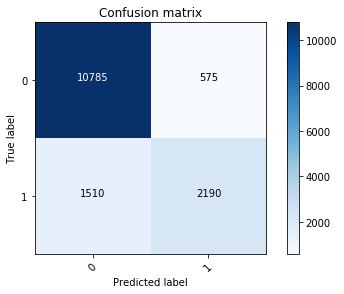

In [30]:
cm = confusion_matrix(Y_test, Y_pred)
if xgb_model.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_cm(cm, ['0', '1'], )

## Accuracy Score

In [31]:
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy: "+str(accuracy * 100.0)+"%")

Accuracy: 86.15537848605578%
